In [1]:
from dotenv import load_dotenv
load_dotenv()
import openai
import json
import os
import random
random.seed(42)
from tqdm import tqdm
import time
import tiktoken
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from classifier_experiments.experiment_utils import load_json_data

In [2]:
# Set up your OpenAI API credentials
AZURE_OPENAI_SERVICE = os.environ.get("AZURE_OPENAI_SERVICE") or ""
AZURE_OPENAI_API_KEY = os.environ.get("AZURE_OPENAI_API_KEY") or ""
AZURE_OPENAI_MODEL_NAME = os.environ.get("AZURE_OPENAI_MODEL_NAME") or "gpt-35-turbo"
AZURE_OPENAI_DEPLOYMENT_NAME = os.environ.get("AZURE_OPENAI_DEPLOYMENT_NAME") or "gpt-35-turbo"

OPENAI_API_VERSION = os.environ.get("OPENAI_API_VERSION") or "2023-07-01-preview"

openai.api_type = "azure"
openai.api_base = f"https://{AZURE_OPENAI_SERVICE}.openai.azure.com/"
openai.api_version = OPENAI_API_VERSION
openai.api_key = AZURE_OPENAI_API_KEY

CONTEXT_LENGTH = 16384

In [3]:
def generate_response(messages):
    try:
        completion = openai.ChatCompletion.create(
            engine=AZURE_OPENAI_DEPLOYMENT_NAME, 
            messages=messages, 
            temperature=1,
            stop=None, 
            presence_penalty=1
        )
    except Exception as e:
        print("Error generating response:", e)
        return ""
    return completion.choices[0].message.content

In [4]:
def load_raw_articles(filename):
    articles = []
    with open(filename) as file:
        json_list = list(file)
        for json_str in json_list:
            article = json.loads(json_str)
            articles.append(article)
    return articles

In [5]:
def get_templates(categories, title, section):
    categories_enumerated = "\n".join([f"- {cat}" for idx, cat in enumerate(categories)])
    system_template = f'''
Your task is to classify sections of a news article into specific categories. These categories encompass a range of topics, such as artificial intelligence, autonomous transport, sustainable fabrics, and more. However, it can be challenging to clearly differentiate between these categories at times, as some articles may cover multiple topics. For instance, artificial intelligence might play a significant role in autonomous driving, drones, and various other applications. However, an article should only be labeled as "artificial intelligence" if this topic is the primary focus and not just a supporting element for another topic. A similar example can be made with "3D Printed Clothes" and "Sustainable fabrics". These are the available categories:
{categories_enumerated}
'''
    prompt_template = f'''
Please classify the following article segment by assigning it the most suitable category from the previous list. Only respond with the category name. If you are unsure, please respond with 'unsure'. Do not respond with anything other than a category name or 'unsure'.
Article title: {title}
Segment: {section}
'''
    return system_template, prompt_template

In [6]:
def truncate_messages(messages):
    encoder = tiktoken.encoding_for_model("gpt-3.5-turbo")
    total_length = 0
    for msg in messages:
        total_length += len(encoder.encode(msg['content']))
    if total_length >= CONTEXT_LENGTH - 100:
        messages[-1]['content'] = encoder.decode(encoder.encode(messages[-1]['content'])[:(CONTEXT_LENGTH-total_length)-100])
    return messages

In [7]:
annotated_sections = load_json_data('../data/')
annotated_categories = list(annotated_sections.label.unique())

raw_articles = load_raw_articles('../data/raw_data.jsonl')
annotated_articles = [article for article in raw_articles if article['category'].lower() in [cat for cat in annotated_categories]]

Loaded: 3d_printed_clothes_sentences.jsonl
Loaded: cement_production_sentences.jsonl
Loaded: organic_food_sentences.jsonl
Loaded: shipping_sentences.jsonl
Loaded: sustainable_fabrics_sentences.jsonl
Loaded: artificial_intelligence_sentences.jsonl
Loaded: clothes_designed_for_a_circular_economy_sentences.jsonl
Loaded: autonomous_transport_sentences.jsonl
Loaded: fiber_optic_cables_sentences.jsonl
Loaded: electric_car_sentences.jsonl
Loaded: drone_sentences.jsonl
Loaded: e_health_sentences.jsonl
Loaded: capsule_wardrobe_sentences.jsonl
Loaded: car_sharing_sentences.jsonl
Loaded: smart_food_management_kitchen_fridges_freezers_sentences.jsonl
Loaded: biking_sentences.jsonl
Loaded: rent_apparel_sentences.jsonl


In [8]:
def split_article_into_sections(article, section_length=3, by="sentences"):
    # get the first three sentences in the article
    if by == "sentences":
        sentences = article['text'].split('.')
        sections = []
        for i in range(0, len(sentences), section_length):
            sections.append('.'.join(sentences[i:i+section_length]))
        return sections
    elif by == "words":
        words = article['text'].split(' ')
        sections = []
        for i in range(0, len(words), section_length):
            sections.append(' '.join(words[i:i+section_length]))
        return sections
    else:
        raise ValueError("by must be either 'sentences' or 'words'")

In [9]:
def classify_sections(article_title, sections, categories):
    invalid_responses = []
    predictions = []
    for section in sections:
        system_template, prompt_template = get_templates(categories, article_title, section)
        messages = [
            {"role":"system","content": system_template},
            {"role": "user", "content": prompt_template}
        ]
        messages = truncate_messages(messages)
        response = generate_response(messages).strip().replace('.', '').lower()
        second_prediction = response
        if response not in annotated_categories + ['unsure']:
            invalid_responses.append(response)
            messages.append({"role": "assistant", "content": response})
            messages.append({"role": "user", "content": 'Your response is not valid. It does not match any of the provided categories or "unsure". Please try again.'})
            second_prediction = generate_response(messages).replace('.', '').lower()
        predictions.append({
            "section": section,
            "prediction": response,
            "second_prediction": second_prediction
            })
    return predictions, invalid_responses

# Get Predictions

In [10]:
# example prompt
example_system_prompt, example_prompt = get_templates(annotated_categories, annotated_sections.iloc[0]["title"], annotated_sections.iloc[0]["text"])
print(example_system_prompt)
print(example_prompt)


Your task is to classify sections of a news article into specific categories. These categories encompass a range of topics, such as artificial intelligence, autonomous transport, sustainable fabrics, and more. However, it can be challenging to clearly differentiate between these categories at times, as some articles may cover multiple topics. For instance, artificial intelligence might play a significant role in autonomous driving, drones, and various other applications. However, an article should only be labeled as "artificial intelligence" if this topic is the primary focus and not just a supporting element for another topic. A similar example can be made with "3D Printed Clothes" and "Sustainable fabrics". These are the available categories:
- 3d_printed_clothes
- cement_production
- organic_food
- shipping
- sustainable_fabrics
- artificial_intelligence
- clothes_designed_for_a_circular_economy
- autonomous_transport
- fiber_optic_cables
- electric_car
- drone
- e_health
- capsule

In [11]:
predictions = []
invalid_responses = []
num_articles = 10
num_sections_per_article = 10
progressbar = tqdm(total=len(annotated_categories)*num_articles*num_sections_per_article, position=0, leave=True)
for cat in annotated_categories:
    progressbar.set_description(cat)
    sub = annotated_sections[annotated_sections.label == cat]
    # sample 15 article ids from sub
    num_articles_in_category = len(sub.article_id.unique())
    article_ids = sub.article_id.sample(num_articles if num_articles <= num_articles_in_category else num_articles_in_category).values
    for id in article_ids:
        sub_article = sub[sub.article_id == id]
        sections = list(sub_article.sample(num_sections_per_article if num_sections_per_article <= len(sub_article) else len(sub_article)).text.values)
        title = sub_article.title.values[0]
        article_predictions, sub_invalid_responses = classify_sections(title, sections, annotated_categories)
        invalid_responses += sub_invalid_responses
        for pred in article_predictions:
            pred["article_id"] = id
            pred["category"] = cat
            pred["title"] = title
        predictions += article_predictions
        progressbar.update(num_sections_per_article)
predictions = pd.DataFrame(predictions)
print("Invalid Responses:", invalid_responses)

rent_apparel:  93%|█████████▎| 1580/1700 [05:48<00:26,  4.53it/s]                                  

Invalid Responses: ['sustainable shipping', 'sustainable_shipping', 'unsure there seems to be an error with the segment provided as it does not relate to the article title', 'drones']


## Process Predictions

In [12]:
predictions["prediction_after_processing"] = predictions["second_prediction"]

In [13]:
predictions["match_after_first"] = predictions["category"] == predictions["prediction"]
predictions["match_after_second"] = predictions["category"] == predictions["second_prediction"]

In [14]:
unsure_predictions = predictions[predictions.prediction == "unsure"]
# get all predictions where the second prediction is not in the annotated categories or unsure
ambiguous_predictions = predictions[predictions.second_prediction.isin(annotated_categories + ['unsure']) == False]

In [21]:
# process ambiguous predictions
if len(ambiguous_predictions) > 0:
    print(f"Found {len(ambiguous_predictions)} ambiguous predictions")
    for idx, row in ambiguous_predictions.iterrows():
        print(f"Ambiguous prediction: '{row.prediction}' and '{row.second_prediction}'")
        for cat in annotated_categories:
            if cat in row.prediction or cat in row.second_prediction:
                print(f"predictions were '{row.prediction}' and '{row.second_prediction}' -> but likely '{row.category}' was meant")
                predictions.loc[idx, "prediction_after_processing"] = cat
else:
    print("No ambiguous predictions found")

Found 1 ambiguous predictions
Ambiguous prediction: 'unsure there seems to be an error with the segment provided as it does not relate to the article title' and 'unsure as the given segment does not seem to belong to the article title "towards autonomous transportation", i cannot accurately categorize it without further context'


In [16]:
if len(unsure_predictions) > 0:
    print(f"Found {len(unsure_predictions)} 'unsure' predictions:")
    for idx, row in unsure_predictions.iterrows():
        print(f'idx: {idx}')
        print(f'category: {row.category}')
        print(f'title: {row.title}')
        print(f'prediction: {row.prediction}')
        print(f'second_prediciton: {row.second_prediction}')
        print(f"")
else:
    print("No unsure predictions found")

Found 19 'unsure' predictions:
idx: 269
category: shipping
title: Sustainable shipping forum
prediction: unsure
second_prediciton: unsure

idx: 456
category: artificial_intelligence
title: How artificial intelligence will affect the future of energy and climate
prediction: unsure
second_prediciton: unsure

idx: 578
category: autonomous_transport
title: Towards Autonomous Transportation. Passengers’ Experiences, Perceptions and Feelings in a Driverless Shuttle Bus in Finland
prediction: unsure
second_prediciton: unsure

idx: 580
category: autonomous_transport
title: Towards Autonomous Transportation. Passengers’ Experiences, Perceptions and Feelings in a Driverless Shuttle Bus in Finland
prediction: unsure
second_prediciton: unsure

idx: 581
category: autonomous_transport
title: Towards Autonomous Transportation. Passengers’ Experiences, Perceptions and Feelings in a Driverless Shuttle Bus in Finland
prediction: unsure
second_prediciton: unsure

idx: 595
category: autonomous_transport
t

In [17]:
predictions["match_after_processing"] = predictions["category"] == predictions["prediction_after_processing"]
print(f'Accuracy first try: {len(predictions.loc[predictions.match_after_first == True])/len(predictions)*100}%')
print(f'Accuracy second try: {len(predictions.loc[predictions.match_after_second == True])/len(predictions)*100}%')
print(f'Accuracy after processing: {len(predictions.loc[predictions.match_after_processing == True])/len(predictions)*100}%')

Accuracy first try: 91.27645926876203%
Accuracy second try: 91.27645926876203%
Accuracy after processing: 91.27645926876203%


In [18]:
def plot_confusion_matrix(df, title="Confusion Matrix"):
    cm = confusion_matrix(df['category'], df['prediction_after_processing'], labels=annotated_categories)
    plt.figure(figsize=(8,8))
    g = sns.heatmap(cm, annot=True, fmt='g', xticklabels=annotated_categories , yticklabels=annotated_categories, cmap='Blues')
    g.set_title(title)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')

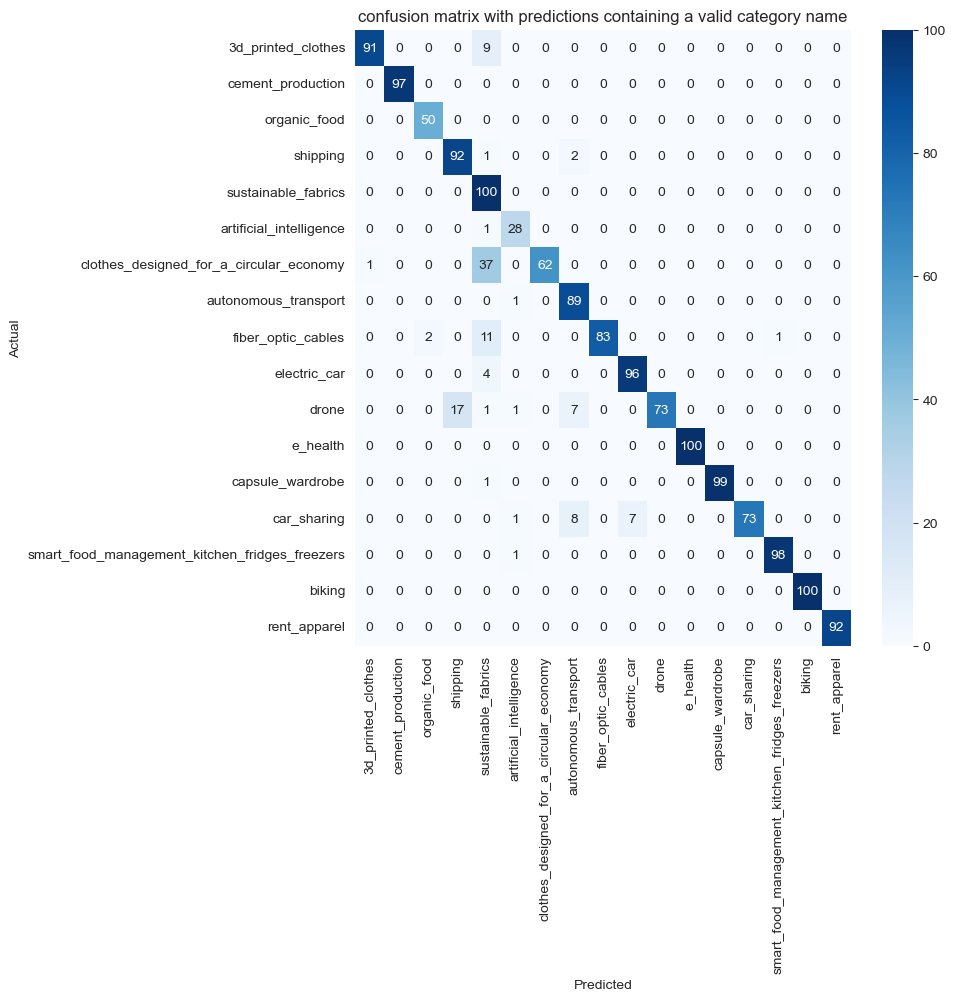

In [19]:
predictions_with_valid_category_name = predictions[predictions.prediction_after_processing.isin(annotated_categories)]
plot_confusion_matrix(predictions_with_valid_category_name, title="confusion matrix with predictions containing a valid category name")